### ATTENTIONAL FUSION CNN

Processing files: 100%|██████████| 5000/5000 [01:15<00:00, 66.43it/s]



Loaded 5000 samples
Epoch 1/100


2025-06-05 21:24:09.421017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-06-05 21:24:11.827932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-05 21:24:12.097417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


110/110 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.0740 - auc: 0.6442

2025-06-05 21:24:36.241957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-06-05 21:24:36.441148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 30s 213ms/step - loss: 1.1716 - accuracy: 0.0740 - auc: 0.6442 - val_loss: 0.6782 - val_accuracy: 0.2453 - val_auc: 0.8624 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - 21s 193ms/step - loss: 0.8283 - accuracy: 0.1760 - auc: 0.7870 - val_loss: 0.5270 - val_accuracy: 0.3413 - val_auc: 0.9090 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - 24s 218ms/step - loss: 0.6871 - accuracy: 0.2483 - auc: 0.8431 - val_loss: 0.4587 - val_accuracy: 0.4193 - val_auc: 0.9209 - lr: 1.0000e-04
Epoch 4/100
110/110 [==============================] - 31s 281ms/step - loss: 0.6030 - accuracy: 0.3046 - auc: 0.8734 - val_loss: 0.4125 - val_accuracy: 0.4767 - val_auc: 0.9312 - lr: 1.0000e-04
Epoch 5/100
110/110 [==============================] - 39s 353ms/step - loss: 0.5521 - accuracy: 0.3437 - auc: 0.8878 - val_loss: 0.3658 - val_accuracy: 0.5307 - val_auc: 0.9434 - lr: 1.0000e-04
Epoch 6/100
110/110 [================

2025-06-05 22:28:44.169036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 58ms/step


2025-06-05 22:28:53.726836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 769ms/step

Evaluation Metrics Summary:
Accuracy: 0.7807
Balanced Accuracy: 0.7807
Matthews Correlation: 0.7765
Cohen's Kappa: 0.7762
AUC (OvR): 0.9864
AUC (OvO): 0.9864
Weighted Avg F1: 0.7774
Macro Avg F1: 0.7774

Detailed Classification Report:
                            precision    recall  f1-score   support

               Andean Guan       0.71      0.83      0.77        30
          Band-tailed Guan       0.64      0.60      0.62        30
            Barred Tinamou       0.83      1.00      0.91        30
        Bartlett's Tinamou       0.79      0.50      0.61        30
                Baudo Guan       0.69      0.73      0.71        30
              Bearded Guan       0.75      0.60      0.67        30
       Berlepsch's Tinamou       0.66      0.70      0.68        30
            Biak Scrubfowl       0.71      0.57      0.63        30
      Black-capped Tinamou       0.65      0.73      0.69        30
 Black-fronted Piping Guan   

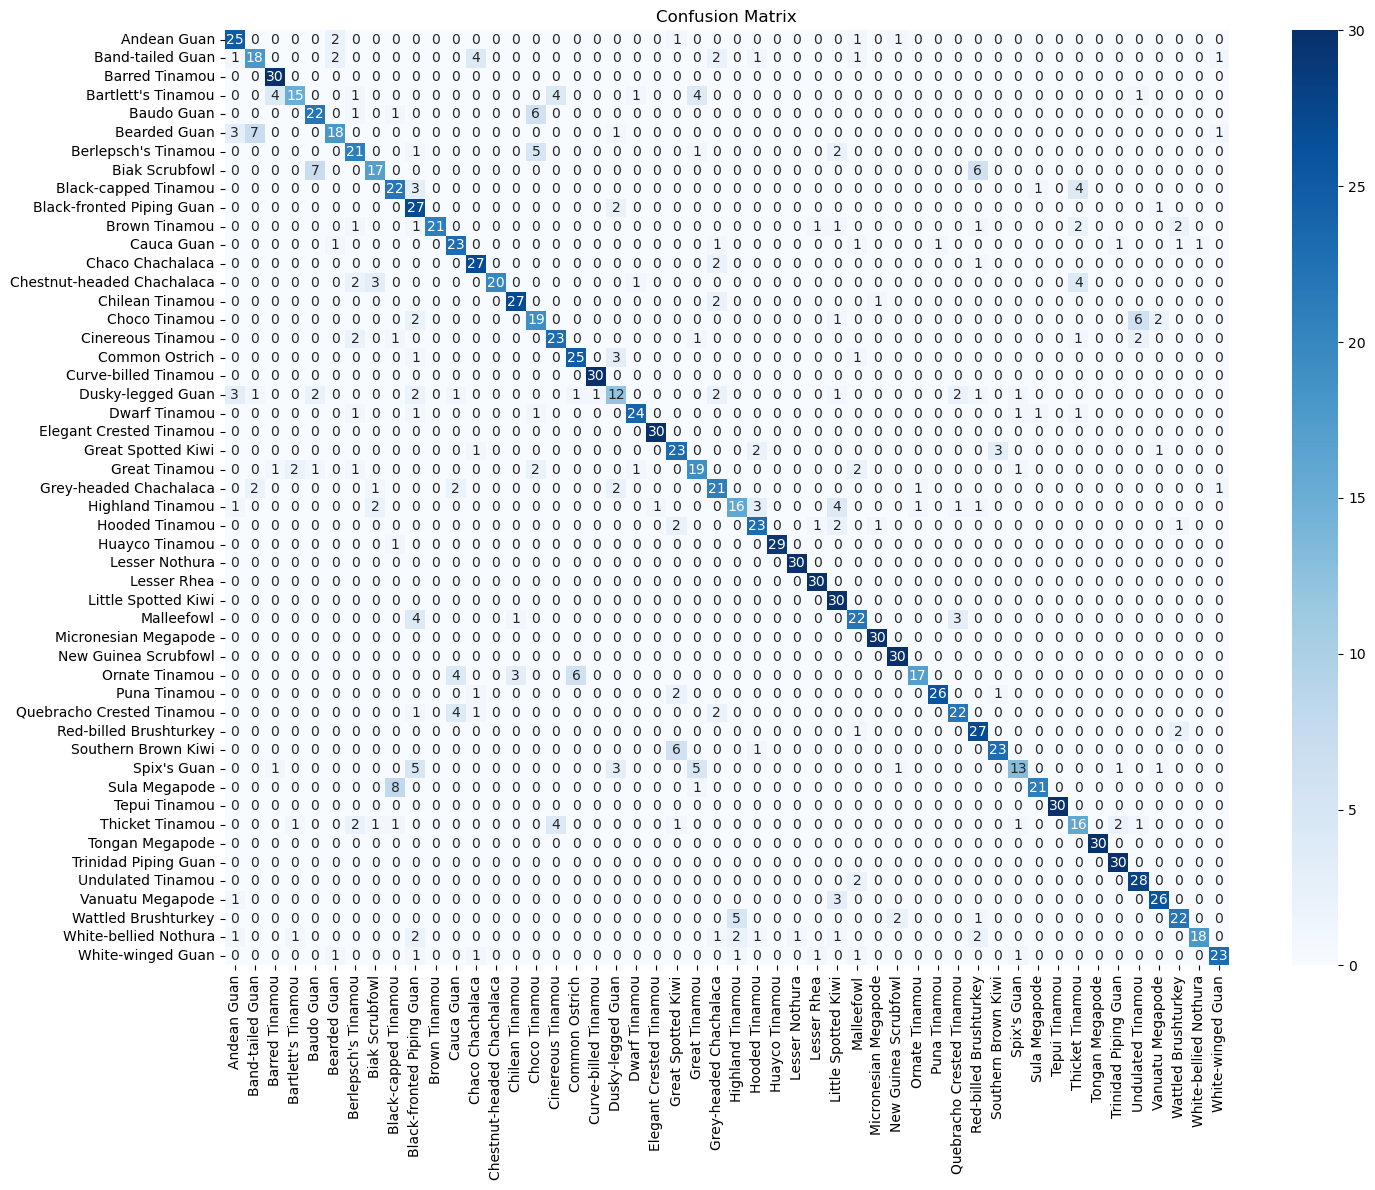

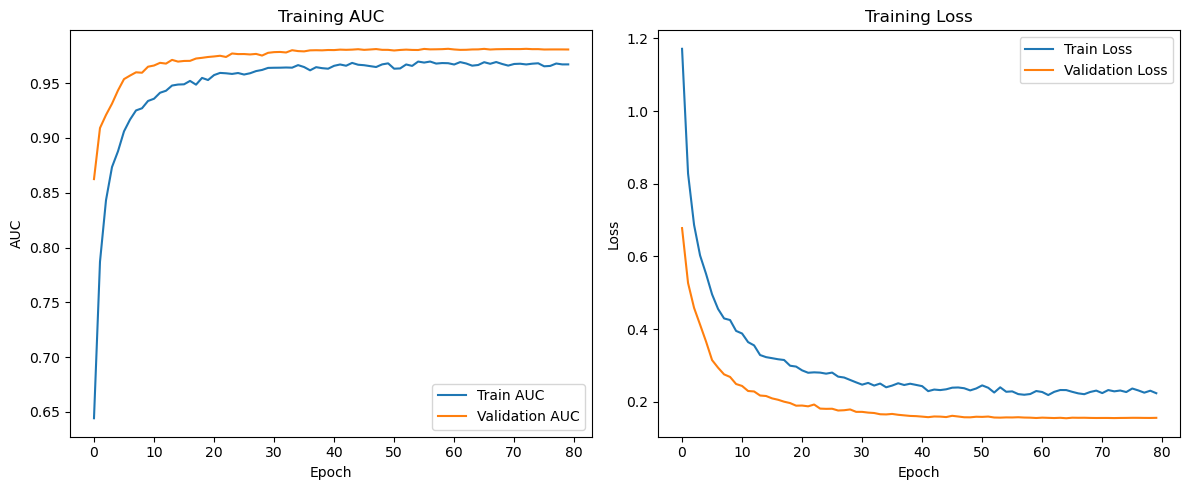

In [7]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             precision_recall_fscore_support, accuracy_score, 
                             balanced_accuracy_score, matthews_corrcoef, 
                             cohen_kappa_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
AUDIO_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s_TOP50'
FEATURES_DIR = DATA_DIR / 'features/birdcall_features_TOP50.csv'
MODEL_DIR = BASE_DIR / 'models'  # New directory for model storage
METRICS_DIR = BASE_DIR / 'metrics'  # New directory for metrics storage

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
# Audio parameters
SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = 259

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 1e-4

def clean_filename(fname):
    return os.path.splitext(os.path.basename(fname))[0]

def load_and_preprocess_audio(file_path):
    """Audio preprocessing without augmentation"""
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS,
                                         n_fft=N_FFT, hop_length=HOP_LENGTH)
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        # Normalize
        S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB) + 1e-8)
        
        # Padding
        if S_dB.shape[1] < MAX_PAD_LEN:
            pad_width = MAX_PAD_LEN - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0,0), (0,pad_width)), mode='constant')
        else:
            S_dB = S_dB[:, :MAX_PAD_LEN]
            
        return S_dB[..., np.newaxis]
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

class AudioFeatureGenerator(tf.keras.utils.Sequence):
    """Custom data generator without augmentation"""
    def __init__(self, audio_data, feature_data, labels, batch_size=32, shuffle=True):
        self.audio_data = audio_data
        self.feature_data = feature_data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(audio_data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_audio = []
        X_features = []
        y = []
        
        for i in batch_indices:
            X_audio.append(self.audio_data[i])
            X_features.append(self.feature_data[i])
            y.append(self.labels[i])
            
        # Convert labels to one-hot encoding
        y_onehot = to_categorical(y, num_classes=len(np.unique(self.labels)))
        return [np.array(X_audio), np.array(X_features)], y_onehot

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def build_enhanced_model(audio_shape, feature_dim, num_classes):
    """Model architecture without augmentation-related components"""
    # Audio branch
    audio_input = Input(shape=audio_shape, name='audio_input')
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(audio_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    audio_output = layers.Dense(64, activation='relu')(x)

    # Feature branch
    feature_input = Input(shape=(feature_dim,), name='feature_input')
    f = layers.Dense(128, activation='relu')(feature_input)
    f = layers.BatchNormalization()(f)
    feature_output = layers.Dense(64, activation='relu')(f)

    # Cross-modal attention
    attention = layers.Attention()([audio_output[:, None], feature_output[:, None]])
    attention = layers.Flatten()(attention)

    # Fusion
    merged = layers.concatenate([audio_output, feature_output, attention])
    
    # Classifier
    x = layers.Dense(512, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[audio_input, feature_input], outputs=output)

    # Focal loss
    def focal_loss(gamma=2., alpha=0.25):
        def loss_fn(y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
            ce = -y_true * tf.math.log(y_pred)
            weight = tf.pow(1 - y_pred, gamma) * y_true
            fl = ce * weight * alpha
            return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
        return loss_fn

    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss=focal_loss(),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

def create_dataset(features_df, top_features):
    """Create dataset without augmentation"""
    wav_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
    
    X_audio = []
    X_features = []
    y = []
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(features_df['species'])
    
    feature_scaler = StandardScaler()
    features = features_df[top_features].values
    feature_scaler.fit(features)
    
    for wav_file in tqdm(wav_files, desc="Processing files"):
        file_id = clean_filename(wav_file)
        try:
            row = features_df[features_df['filename'].str.contains(file_id)].iloc[0]
            audio_path = os.path.join(AUDIO_DIR, wav_file)
            spec = load_and_preprocess_audio(audio_path)
            if spec is None:
                continue
                
            features = row[top_features].values.astype(np.float32)
            features = feature_scaler.transform(features.reshape(1, -1))[0]
            
            X_audio.append(spec)
            X_features.append(features)
            y.append(label_encoder.transform([row['species']])[0])
        except Exception as e:
            print(f"\nError processing {file_id}: {str(e)}")
            continue
    
    print(f"\nLoaded {len(y)} samples")
    return np.array(X_audio), np.array(X_features), np.array(y), label_encoder

def train_model(model, train_gen, val_gen, class_weights):
    """Training function"""
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True),
        ModelCheckpoint('AFCNN.h5', monitor='val_auc', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max')
    ]
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    return history

def evaluate_model(model, test_gen, label_encoder):
    """Enhanced evaluation function with comprehensive metrics"""
    y_true = []
    y_pred = []
    y_pred_proba = []
    
    for batch in test_gen:
        X_batch, y_batch = batch
        batch_pred = model.predict(X_batch)
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
        y_pred_proba.extend(batch_pred)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)
    
    # Convert to one-hot for multiclass metrics
    y_onehot = to_categorical(y_true, num_classes=len(label_encoder.classes_))
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_true, y_pred),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
        'auc_ovr': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovr'),
        'auc_ovo': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovo'),
    }
    
    # Add per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    metrics['per_class'] = {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    
    # Weighted and macro averages
    metrics['weighted_avg'] = {
        'precision': precision_recall_fscore_support(y_true, y_pred, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_true, y_pred, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
    }
    
    metrics['macro_avg'] = {
        'precision': precision_recall_fscore_support(y_true, y_pred, average='macro')[0],
        'recall': precision_recall_fscore_support(y_true, y_pred, average='macro')[1],
        'f1': precision_recall_fscore_support(y_true, y_pred, average='macro')[2]
    }
    
    # Save metrics to JSON file
    metrics_file = METRICS_DIR / 'evaluation_metrics_AFCNN.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Print summary metrics
    print("\nEvaluation Metrics Summary:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"Matthews Correlation: {metrics['matthews_corrcoef']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print(f"AUC (OvR): {metrics['auc_ovr']:.4f}")
    print(f"AUC (OvO): {metrics['auc_ovo']:.4f}")
    print(f"Weighted Avg F1: {metrics['weighted_avg']['f1']:.4f}")
    print(f"Macro Avg F1: {metrics['macro_avg']['f1']:.4f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'confusion_matrix_AFCNN.png', dpi=300)
    plt.show()
    
    return metrics

if __name__ == "__main__":
    # Load and prepare data
    features_df = pd.read_csv(FEATURES_DIR)
    
     # Predefined top features
    top_features = [
    'lowlevel.spectral_energyband_middle_low.stdev',
    'lowlevel.hfc.stdev',
    'lowlevel.pitch_salience.stdev',
    'lowlevel.spectral_centroid.mean',
    'lowlevel.spectral_energyband_high.stdev',
    'lowlevel.spectral_complexity.mean',
    'lowlevel.spectral_decrease.stdev',
    'lowlevel.spectral_strongpeak.stdev',
    'lowlevel.spectral_complexity.stdev',
    'lowlevel.spectral_energyband_middle_low.mean',
    'lowlevel.spectral_strongpeak.mean',
    'lowlevel.loudness_ebu128.integrated',
    'lowlevel.erbbands_skewness.mean',
    'lowlevel.pitch.mean',
    'lowlevel.spectral_flux.stdev',
    'lowlevel.spectral_rolloff.mean',
    'lowlevel.spectral_energyband_middle_high.mean',
    'lowlevel.pitch_salience.mean'
]
    
    # Create dataset
    X_audio, X_features, y, label_encoder = create_dataset(features_df, top_features)
    
    # Split data
    (X_audio_train, X_audio_test, 
     X_feat_train, X_feat_test,
     y_train, y_test) = train_test_split(
        X_audio, X_features, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )
    
    # Create data generators
    train_gen = AudioFeatureGenerator(X_audio_train, X_feat_train, y_train, BATCH_SIZE)
    val_gen = AudioFeatureGenerator(X_audio_test, X_feat_test, y_test, BATCH_SIZE, shuffle=False)
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(enumerate(class_weights))
    
    # Build model
    model = build_enhanced_model(
        audio_shape=X_audio.shape[1:],
        feature_dim=len(top_features),
        num_classes=len(label_encoder.classes_)
    )
    
    # Update ModelCheckpoint to save in MODEL_DIR
    model_file = MODEL_DIR / 'TRAIN_AFCNN.h5'
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True),
        ModelCheckpoint(model_file, monitor='val_auc', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max')
    ]
    
    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save final model
    final_model_file = MODEL_DIR / 'FINAL_AFCNN.h5'
    model.save(final_model_file)
    print(f"\nFinal model saved to {final_model_file}")
    
    # Save training history
    history_file = METRICS_DIR / 'training_history_AFCNN.json'
    # Convert numpy float32 to native Python float
    history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
    with open(history_file, 'w') as f:
        json.dump(history_dict, f, indent=4)
    # Evaluate final model
    print("\nEvaluating Best Model:")
    metrics = evaluate_model(model, val_gen, label_encoder)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'training_history-AFCNN.png', dpi=300)
    plt.show()